# Project 2 – First Draft

## 0. Imports & Versions

In [35]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pickle
from datetime import datetime, timedelta
import time
import re
import sys
import matplotlib.pyplot as plt

% matplotlib inline

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import os
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [4]:
list_of_imports = [('Numpy', np), 
                   ('Pandas', pd), 
#                   ('Beautiful Soup', BeautifulSoup), 
                   ('Selenium', webdriver)
                  ]

for mod in list_of_imports:
    print(f"{mod[0]}: {mod[1].__version__}")

print("Python:", sys.version)

Numpy: 1.12.1
Pandas: 0.20.1
Selenium: 3.6.0
Python: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


## 1. Scraping

In [5]:
def make_flight_url(date_str, flight_num, route_num):
    """
    Takes date string, flight number, and route number, 
    returns URL to search for a particular flight/route/day. 
    ---
    IN: date string YYYYMMDD (str), flight_num (str), route_num (str)
    OUT: search URL (str)
    """

    # base URL constructors
    base_url1 = 'http://flightaware.com/live/flight/'
    base_url2 = '/history/'
    base_url3 = '/KLGA/KORD'
    
    # merge vars with URL bases
    search_url = (base_url1 + flight_num + base_url2 + 
                  date_str + '/' + route_num + base_url3)

    return search_url

In [6]:
def scrape_flight_soup(soup, flight_num, search_date):
    """
    Scrapes pertinient information off single flight page, returns record
    for that flight (one record), returns None if no record for that day.
    ---
    IN: BS4 object of webpage, search date (datetime obj)
    OUT: four flight arrival times (list)
    """
    
    date_str = datetime.strftime(search_date, "%Y%m%d")
    
    # is there a flight that day?
    names = []
    for meta in soup.find_all('meta'):
        names.append(meta.get('name'))
    if not 'airline' in names:
        return 'No Flight'
    
    # was the flight canceled?
    # modify to look at scheduled arrival times, fill actual with 'C'
    # but for now...
    if soup.text.count('cancelled') == 32:
        return 'Canceled'
    
    # if flight arrived
    else:
        try:
            details = soup.find(class_="flightPageDetails")
            details_sub = details.find(attrs={"data-template": "live/flight/details"})
            spans = list(details_sub.find_all('span'))
            arrival_times = []
            fptd_divs = details_sub.find_all(class_="flightPageTimeData")
            
            # pulls from the four relevant indices of fptd_divs
            for i in [9,11,12,14]:
                time_str = fptd_divs[i].text.strip().split(' ')[0]
                arrival_times.append(time_str)
            
            arr_conv = map(lambda x: datetime.strptime(x, "%I:%M%p").time(), arrival_times)
            arrival_times = list(map(lambda x: datetime.combine(search_date, x), arr_conv))
            return arrival_times

        except Exception as e:
            print(f"*** {flight_num}, {date_str}: ERROR: {e}")
            return None

In [7]:
def scrape_fn(days, flight_num, route_num, df=None):
    """
    Goes through a series of steps to gather data for a given flight 
    number and route over a given length of time. Appends each record
    to a dataframe (provided or generated).
    ---
    IN: days, number of days to scrape, starting yesterday (int)
        flight_num, flight number as searched on FlightAware (str)
        route_num, route number as searched on FlightAware (str)
        df, pandas dataframe
    OUT: pandas dataframe
    """
    
    # makes df if none passed
    if df is None:
        df = pd.DataFrame(columns=['airline',
                                   'f_num',
                                   'origin',
                                   'dest',
                                   'date',
                                   'land_act',
                                   'arr_act',
                                   'land_sch',
                                   'arr_sch'])
    # starts Selenium
    driver = webdriver.Chrome(chromedriver)
    
    today = datetime.now().date()
    no_flight_count = 0
    
    # loop to search each date
    for d in range(days):
        time.sleep(np.random.uniform(1.0,2.0))
        search_date = today - timedelta(days=d+1)
        date_str = datetime.strftime(search_date, "%Y%m%d")
        record_a = ['American', flight_num, 'LGA', 'ORD', search_date]
        flight_url = make_flight_url(date_str, flight_num, route_num)
        
        driver.get(flight_url)
        flight_soup = BeautifulSoup(driver.page_source, 'html.parser')
        record_b = scrape_flight_soup(flight_soup, flight_num, search_date)
        
        if record_b == None:
            continue
        
        elif record_b == 'Canceled':
            no_flight_count = 0
            print(f"{flight_num}, {date_str}: canceled")
            continue
        
        elif record_b == 'No Flight':
            no_flight_count += 1
            print(f"{flight_num}, {date_str}: no flight")
            if no_flight_count == 7:
                print(f"{flight_num}: 7 consecutive days of no flights as of {date_str}!")
                break
        else:
            no_flight_count = 0
            record = record_a + record_b
            print(f"{flight_num}, {date_str}: flight data recorded")
            df.loc[len(df)] = record    
    
    driver.close()
    
    return df
    

In [11]:
def multiple_flights(days, flight_list):
    """
    Finds all flights in a list of flight number/route number tuples
    over however many days provided and returns data in a concatenated
    dataframe.
    ---
    IN: number of days to search (int)
        list of flight number/route numbers (string tuples in list)
    OUT: dataframe with all flight info (pandas df)
    """
    
    flight_df = pd.DataFrame(columns=['airline',
                                   'f_num',
                                   'origin',
                                   'dest',
                                   'date',
                                   'land_act',
                                   'arr_act',
                                   'land_sch',
                                   'arr_sch'])
    
    for fn, rn in flight_list:
        flight_df = scrape_fn(days, fn, rn, df=flight_df)

    return flight_df

In [8]:
# All the LGA-ORD flights:

flight_urls = [
"http://flightaware.com/live/flight/AAL321/history/20171003/0130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL371/history/20171003/0030Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL359/history/20171002/2330Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL361/history/20171002/2230Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL383/history/20171002/2200Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL345/history/20171002/2130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL343/history/20171002/2030Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL358/history/20171002/1930Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL187/history/20171002/1830Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL332/history/20171002/1730Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL390/history/20171002/1630Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL337/history/20171002/1530Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL328/history/20171002/1430Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL373/history/20171002/1330Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL1619/history/20171002/1230Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL289/history/20171002/1130Z/KLGA/KORD",
"http://flightaware.com/live/flight/AAL304/history/20171002/1030Z/KLGA/KORD"
]

In [9]:
# if I have time, I'll write a function to get this by scraping.
# but for now, the 'manual' way...

flights = []
for url in flight_urls:
    fn_p = re.compile(r'AAL\d{3,4}')
    rn_p = re.compile(r'\d{4}Z')
    fn = fn_p.search(url).group()
    rn = rn_p.search(url).group()
    flights.append((fn,rn))

In [15]:
AAL321_df = scrape_fn(20, 'AAL321', '0130Z')

AAL321, 20171002: flight data recorded
AAL321, 20171001: no flight
AAL321, 20170930: flight data recorded
AAL321, 20170929: flight data recorded
AAL321, 20170928: flight data recorded
AAL321, 20170927: flight data recorded
AAL321, 20170926: flight data recorded
AAL321, 20170925: flight data recorded
AAL321, 20170924: no flight
AAL321, 20170923: flight data recorded
AAL321, 20170922: flight data recorded
AAL321, 20170921: flight data recorded
AAL321, 20170920: flight data recorded
AAL321, 20170919: flight data recorded
AAL321, 20170918: flight data recorded
AAL321, 20170917: no flight
AAL321, 20170916: flight data recorded
AAL321, 20170915: flight data recorded
AAL321, 20170914: flight data recorded
AAL321, 20170913: flight data recorded


In [ ]:
AAL371_df = scrape_fn(365, 'AAL371', '0030Z')

In [ ]:
AAL358_df = scrape_fn(365, 'AAL358', '1930Z')

In [ ]:
AAL_df = multiple_flights(365, flights)

## 2. MVP Exercise

#### Retrieving Pickles

In [4]:
with open('../pickles/AAL321.pkl', 'rb') as picklefile: 
    AAL321_df = pickle.load(picklefile)

In [5]:
AAL321_df

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch
0,American,AAL321,LGA,ORD,2017-10-02,2017-10-02 22:35:00,2017-10-02 22:40:00,2017-10-02 22:52:00,2017-10-02 23:09:00
1,American,AAL321,LGA,ORD,2017-09-30,2017-09-30 22:32:00,2017-09-30 22:45:00,2017-09-30 22:59:00,2017-09-30 23:09:00
2,American,AAL321,LGA,ORD,2017-09-29,2017-09-29 22:46:00,2017-09-29 22:53:00,2017-09-29 23:01:00,2017-09-29 23:09:00
3,American,AAL321,LGA,ORD,2017-09-28,2017-09-28 22:36:00,2017-09-28 22:44:00,2017-09-28 22:59:00,2017-09-28 23:09:00
4,American,AAL321,LGA,ORD,2017-09-27,2017-09-27 22:31:00,2017-09-27 22:39:00,2017-09-27 22:54:00,2017-09-27 23:09:00
5,American,AAL321,LGA,ORD,2017-09-26,2017-09-26 22:36:00,2017-09-26 22:43:00,2017-09-26 22:49:00,2017-09-26 23:09:00
6,American,AAL321,LGA,ORD,2017-09-25,2017-09-25 22:36:00,2017-09-25 22:42:00,2017-09-25 22:47:00,2017-09-25 23:09:00
7,American,AAL321,LGA,ORD,2017-09-23,2017-09-23 23:07:00,2017-09-23 23:15:00,2017-09-23 22:14:00,2017-09-23 23:09:00
8,American,AAL321,LGA,ORD,2017-09-22,2017-09-22 22:57:00,2017-09-22 23:07:00,2017-09-22 22:49:00,2017-09-22 23:09:00
9,American,AAL321,LGA,ORD,2017-09-21,2017-09-21 22:39:00,2017-09-21 22:43:00,2017-09-21 22:45:00,2017-09-21 23:09:00


In [23]:
AAL321_df['lateness_land'] = AAL321_df['land_act'] - AAL321_df['land_sch']

In [24]:
AAL321_df['lateness_arr'] = AAL321_df['arr_act'] - AAL321_df['arr_sch']

85380

In [76]:
AAL321_df

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr,land_act_t,arr_act_t,land_sch_t,arr_sch_t,weekday
0,American,AAL321,LGA,ORD,2017-10-02,2017-10-02 22:35:00,2017-10-02 22:40:00,2017-10-02 22:52:00,2017-10-02 23:09:00,-1 days +23:43:00,-1 days +23:31:00,22:35:00,22:40:00,22:52:00,23:09:00,0
1,American,AAL321,LGA,ORD,2017-09-30,2017-09-30 22:32:00,2017-09-30 22:45:00,2017-09-30 22:59:00,2017-09-30 23:09:00,-1 days +23:33:00,-1 days +23:36:00,22:32:00,22:45:00,22:59:00,23:09:00,5
2,American,AAL321,LGA,ORD,2017-09-29,2017-09-29 22:46:00,2017-09-29 22:53:00,2017-09-29 23:01:00,2017-09-29 23:09:00,-1 days +23:45:00,-1 days +23:44:00,22:46:00,22:53:00,23:01:00,23:09:00,4
3,American,AAL321,LGA,ORD,2017-09-28,2017-09-28 22:36:00,2017-09-28 22:44:00,2017-09-28 22:59:00,2017-09-28 23:09:00,-1 days +23:37:00,-1 days +23:35:00,22:36:00,22:44:00,22:59:00,23:09:00,3
4,American,AAL321,LGA,ORD,2017-09-27,2017-09-27 22:31:00,2017-09-27 22:39:00,2017-09-27 22:54:00,2017-09-27 23:09:00,-1 days +23:37:00,-1 days +23:30:00,22:31:00,22:39:00,22:54:00,23:09:00,2
5,American,AAL321,LGA,ORD,2017-09-26,2017-09-26 22:36:00,2017-09-26 22:43:00,2017-09-26 22:49:00,2017-09-26 23:09:00,-1 days +23:47:00,-1 days +23:34:00,22:36:00,22:43:00,22:49:00,23:09:00,1
6,American,AAL321,LGA,ORD,2017-09-25,2017-09-25 22:36:00,2017-09-25 22:42:00,2017-09-25 22:47:00,2017-09-25 23:09:00,-1 days +23:49:00,-1 days +23:33:00,22:36:00,22:42:00,22:47:00,23:09:00,0
7,American,AAL321,LGA,ORD,2017-09-23,2017-09-23 23:07:00,2017-09-23 23:15:00,2017-09-23 22:14:00,2017-09-23 23:09:00,00:53:00,00:06:00,23:07:00,23:15:00,22:14:00,23:09:00,5
8,American,AAL321,LGA,ORD,2017-09-22,2017-09-22 22:57:00,2017-09-22 23:07:00,2017-09-22 22:49:00,2017-09-22 23:09:00,00:08:00,-1 days +23:58:00,22:57:00,23:07:00,22:49:00,23:09:00,4
9,American,AAL321,LGA,ORD,2017-09-21,2017-09-21 22:39:00,2017-09-21 22:43:00,2017-09-21 22:45:00,2017-09-21 23:09:00,-1 days +23:54:00,-1 days +23:34:00,22:39:00,22:43:00,22:45:00,23:09:00,3


In [79]:
AAL321_df.loc[6, 'lateness_land'].seconds

85740

In [80]:
jr = AAL321_df

In [81]:
jr.head()

,airline,f_num,origin,dest,date,land_act,arr_act,land_sch,arr_sch,lateness_land,lateness_arr,land_act_t,arr_act_t,land_sch_t,arr_sch_t,weekday
0,American,AAL321,LGA,ORD,2017-10-02,2017-10-02 22:35:00,2017-10-02 22:40:00,2017-10-02 22:52:00,2017-10-02 23:09:00,-1 days +23:43:00,-1 days +23:31:00,22:35:00,22:40:00,22:52:00,23:09:00,0
1,American,AAL321,LGA,ORD,2017-09-30,2017-09-30 22:32:00,2017-09-30 22:45:00,2017-09-30 22:59:00,2017-09-30 23:09:00,-1 days +23:33:00,-1 days +23:36:00,22:32:00,22:45:00,22:59:00,23:09:00,5
2,American,AAL321,LGA,ORD,2017-09-29,2017-09-29 22:46:00,2017-09-29 22:53:00,2017-09-29 23:01:00,2017-09-29 23:09:00,-1 days +23:45:00,-1 days +23:44:00,22:46:00,22:53:00,23:01:00,23:09:00,4
3,American,AAL321,LGA,ORD,2017-09-28,2017-09-28 22:36:00,2017-09-28 22:44:00,2017-09-28 22:59:00,2017-09-28 23:09:00,-1 days +23:37:00,-1 days +23:35:00,22:36:00,22:44:00,22:59:00,23:09:00,3
4,American,AAL321,LGA,ORD,2017-09-27,2017-09-27 22:31:00,2017-09-27 22:39:00,2017-09-27 22:54:00,2017-09-27 23:09:00,-1 days +23:37:00,-1 days +23:30:00,22:31:00,22:39:00,22:54:00,23:09:00,2


In [82]:
jr['land_act_hour'] = jr['land_act'].apply(lambda x: x.hour)

In [84]:
jr['land_sch_hour'] = jr['land_sch'].apply(lambda x: x.hour)

In [85]:
jr['land_hr_diff'] = jr['land_act_hour'] - jr['land_sch_hour']

In [86]:
jr['land_hr_diff']

0     0
1     0
2    -1
3     0
4     0
5     0
6     0
7     1
8     0
9     0
10    0
11    0
13    0
14    0
15    0
16    0
Name: land_hr_diff, dtype: int64

In [ ]:
# AAL321_df['lateness_land'] = AAL321_df.apply(lambda x: x['lateness_land'].seconds, type=1)

In [39]:
AAL321_df['land_act_t'] = AAL321_df.apply(lambda x: x['land_act'].time(), axis=1)

In [41]:
AAL321_df['arr_act_t'] = AAL321_df.apply(lambda x: x['arr_act'].time(), axis=1)

In [42]:
AAL321_df['land_sch_t'] = AAL321_df.apply(lambda x: x['land_sch'].time(), axis=1)

In [45]:
AAL321_df['arr_sch_t'] = AAL321_df.apply(lambda x: x['arr_sch'].time(), axis=1)

In [53]:
AAL321_df['weekday'] = AAL321_df.apply(lambda x: x['land_sch'].weekday(), axis=1)

In [59]:
AAL321_df.drop(AAL321_df.index[12], inplace=True)

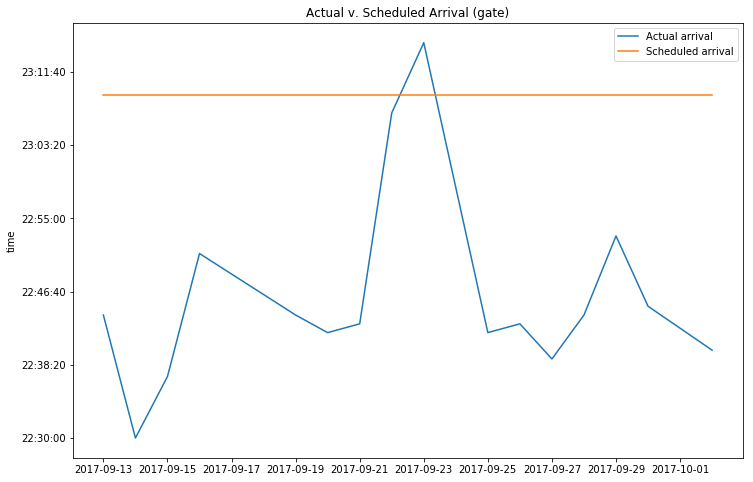

In [74]:
x = AAL321_df.date
y1 = AAL321_df.arr_act_t
y2 = AAL321_df.arr_sch_t

plt.figure(figsize=(12,8))
plt.plot(x,y1, label='Actual arrival')
plt.plot(x,y2, label='Scheduled arrival')
plt.legend()
plt.title("Actual v. Scheduled Arrival (gate)");

The only data currently available — AAL321 arrivals since late September.

In [71]:
AAL321_sorted = AAL321_df.sort_values(by=['weekday', 'date'])

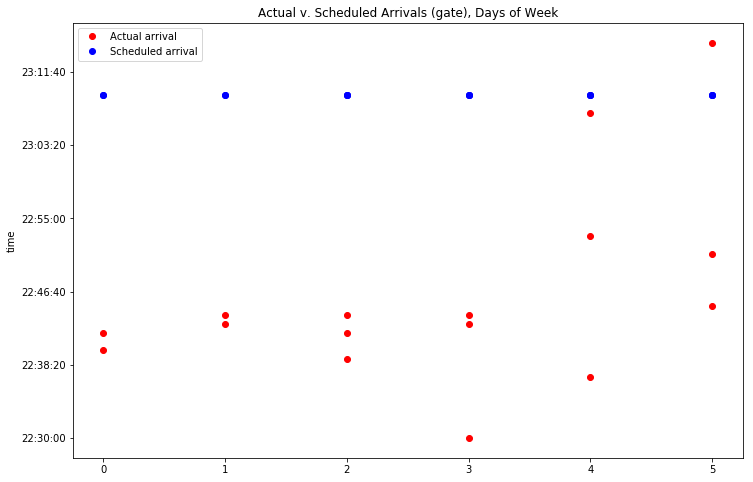

In [75]:
x = AAL321_sorted.weekday
y1 = AAL321_sorted.arr_act_t
y2 = AAL321_sorted.arr_sch_t

plt.figure(figsize=(12,8))
plt.plot(x,y1, "ro", label='Actual arrival')
plt.plot(x,y2, "bo", label='Scheduled arrival')
plt.legend()
plt.title("Actual v. Scheduled Arrivals (gate), Days of Week");

At first glance, some possible correlation between day of week and ETA, but not enough data to even begin to explore.